# Pose Estimation

**What is pose estimation**
Pose estimation predicts different poses based on a person’s body parts and joint positioning in an image or video. We can automatically detect the joints, arms, hips, and spine position while performing a squat.

Use cases:
- Athlete rehabilitating after an injury or undergoing strength training; the pose estimation may help sports analysts analyze vital points from the starting position to the end position of a squat

## TF Hub models found here

https://tfhub.dev/s?q=movenet

Note there are other pose models ... (https://tfhub.dev/s?q=image%20pose%20detection)

### MoveNet Lite Tutorial

https://www.youtube.com/watch?v=SSW9LzOJSus&t=205s

In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time


2022-11-08 14:11:11.753599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 14:11:11.882563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/cv2/../../lib64:
2022-11-08 14:11:11.882580: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-08 14:11:11.902499: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register 

In [3]:
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

POSE_LANDMARKS = [m.name for m in mp_pose.PoseLandmark]

In [4]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 


def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

In [5]:
interpreter = tf.lite.Interpreter(model_path="lite-model_movenet_singlepose_lightning_3.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 1.) Show mp4 with 2D keypoints and edges

In [6]:
cap = cv2.VideoCapture('inputs/golf/side_angle/fast/side_fast_3.mp4')

while(cap.isOpened()):
    time.sleep(0.05)
    ret, frame = cap.read()
    
    
    if ret == True:
        # img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # cv2.imshow('frame', img_rgb)
        
        # Reshape image
        img = frame.copy()
        img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
        input_image = tf.cast(img, dtype=tf.float32)

        # Setup input and output 
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Make predictions 
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        interpreter.invoke()
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

        # Rendering 
        draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
        draw_keypoints(frame, keypoints_with_scores, 0.4)

        cv2.imshow('MoveNet Lightning', frame)
        
        # & 0xFF is required for a 64-bit system
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
        

cap.release()
cv2.destroyAllWindows()

2022-11-08 14:11:13.983451: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-08 14:11:13.983477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Ryan-Asus): /proc/driver/nvidia/version does not exist
2022-11-08 14:11:13.984046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.) Show mp4 with 3D keypoints and edges using MediaPose

Issue - not managing to render plot correctly for multiplt instances

Solutions?
Animation type solution
Try and find out how to clear a graph and then rerender it smoothly using the same axis ? Surely its easy

In [7]:

def _normalize_color(color):
     return tuple(v / 255. for v in color)

def custom_plot_landmarks(
    landmark_list,
    ax,
    add_connections: bool = True,
    landmark_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.RED_COLOR, thickness=5),
    connection_drawing_spec: mp_drawing.DrawingSpec = mp_drawing.DrawingSpec(color=mp_drawing.BLACK_COLOR, thickness=5),
    elevation: int = 10,
    azimuth: int = 10,
    visibility_threshold=0.5,
    presence_threshold=0.5,
):
    """Plot the landmarks and the connections in matplotlib 3d.
    Args:
    landmark_list: A normalized landmark list proto message to be plotted.
    connections: A list of landmark index tuples that specifies how landmarks to
      be connected.
    landmark_drawing_spec: A DrawingSpec object that specifies the landmarks'
      drawing settings such as color and line thickness.
    connection_drawing_spec: A DrawingSpec object that specifies the
      connections' drawing settings such as color and line thickness.
    elevation: The elevation from which to view the plot.
    azimuth: the azimuth angle to rotate the plot.
    Raises: ValueError: If any connetions contain invalid landmark index.
    """
    if not landmark_list:
        return

    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if ((landmark.HasField('visibility') and landmark.visibility < visibility_threshold) or
            (landmark.HasField('presence') and landmark.presence < presence_threshold)):
            continue
        
        ax.scatter3D(
            xs=[-landmark.z],
            ys=[landmark.x],
            zs=[-landmark.y],
            color=_normalize_color(landmark_drawing_spec.color[::-1]),
            linewidth=landmark_drawing_spec.thickness
        )
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
        # graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

        
        # ax.plot(
        #     xs=[-landmark.z],
        #     ys=[landmark.x],
        #     zs=[-landmark.y],
        #     color=_normalize_color(landmark_drawing_spec.color[::-1]),
        #     linewidth=landmark_drawing_spec.thickness,
        #     marker="o",
        #     # s=5
        # )
        
    if add_connections:
        num_landmarks = len(landmark_list.landmark)
        
        # Draws the connections if the start and end landmarks are both visible.
        connections = mp_pose.POSE_CONNECTIONS
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx], plotted_landmarks[end_idx]
                ]
                ax.plot3D(
                    xs=[landmark_pair[0][0], landmark_pair[1][0]],
                    ys=[landmark_pair[0][1], landmark_pair[1][1]],
                    zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    color=_normalize_color(connection_drawing_spec.color[::-1]),
                    linewidth=connection_drawing_spec.thickness
                )
    
    return ax

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


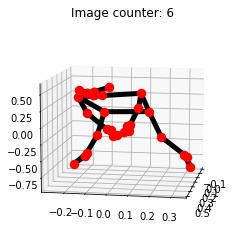

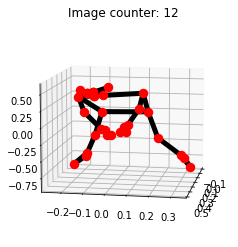

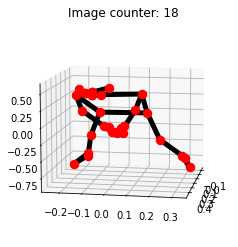

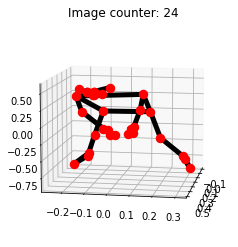

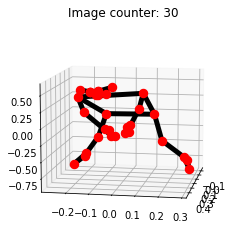

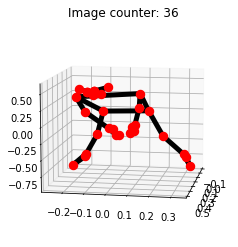

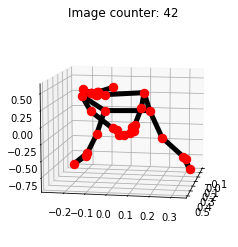

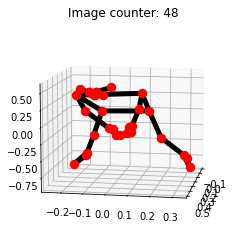

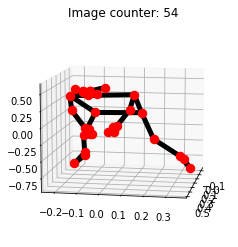

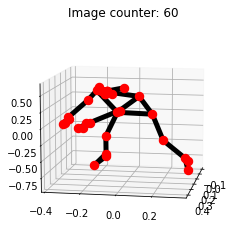

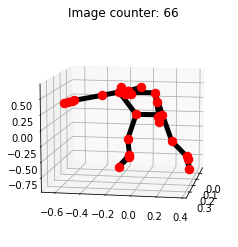

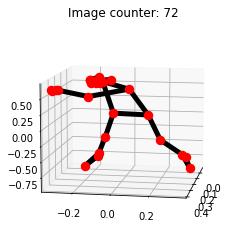

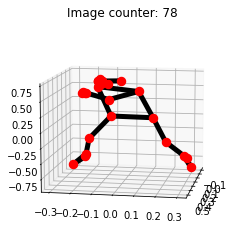

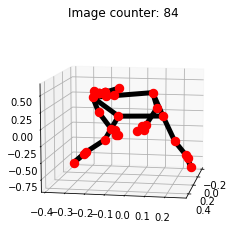

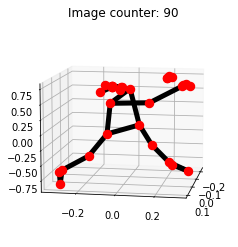

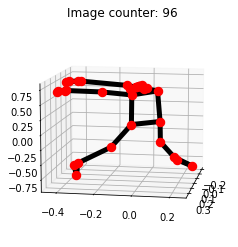

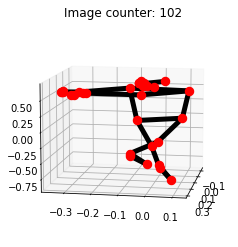

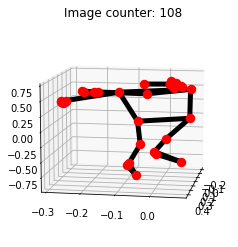

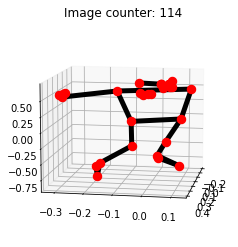

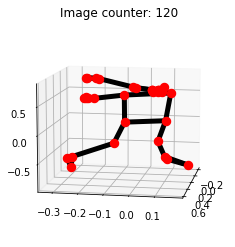

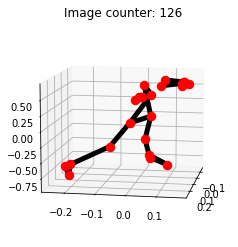

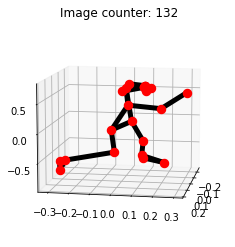

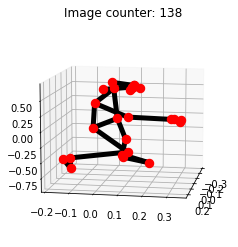

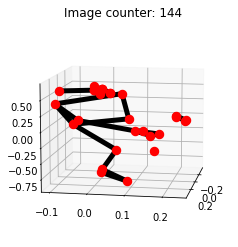

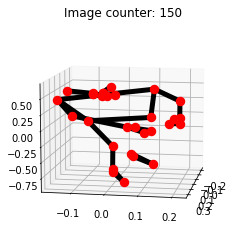

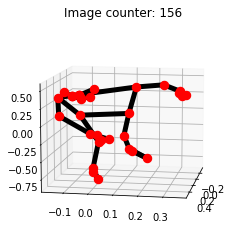

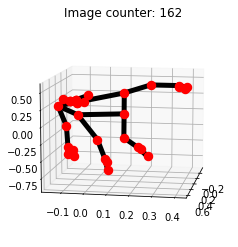

In [8]:
cap = cv2.VideoCapture('inputs/golf/side_angle/fast/side_fast_3.mp4')


result_arr = []


i_img_counter = 0

with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=1, 
) as pose:
    while(cap.isOpened()):
        ret, frame = cap.read()
        
        if ret == True:
            i_img_counter += 1
            if not i_img_counter % 6 == 0:
                continue

            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            results = pose.process(img_rgb)
            result_arr.append(results)
            
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(elev=10, azim=10)

            # Plot the results to the 3d rendered plots
            custom_plot_landmarks(results.pose_world_landmarks, add_connections=True, ax=ax)
            ax.set_title(f"Image counter: {i_img_counter}")
            plt.show()
            time.sleep(0.05)

            # & 0xFF is required for a 64-bit system
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break


    cap.release()
    cv2.destroyAllWindows()

In [9]:
single_frame_landmarks = [result_ar.pose_world_landmarks.landmark for result_ar in result_arr]
single_frame_landmarks[0][8]

x: -0.16031205654144287
y: -0.5131022334098816
z: -0.37002167105674744
visibility: 0.9999268054962158

In [11]:
def populate_keypoint_gif_dict(result_arr):
    single_frame_landmarks = [result_ar.pose_world_landmarks.landmark for result_ar in result_arr]
    keypoints_dict = {}
    

    for i_time_stamp, single_frame_l in enumerate(single_frame_landmarks):
        keypoints_dict[i_time_stamp] = {}
        keypoints_dict[i_time_stamp]['nodes'] = {}
        keypoints_dict[i_time_stamp]['connections'] = []
        
        for i in range(0, len(POSE_LANDMARKS)):
            # Fetch xyz point for each poselandmark
            xs= -1 * single_frame_l[i].z
            ys= single_frame_l[i].x
            zs= -1 * single_frame_l[i].y
            keypoints_dict[i_time_stamp]['nodes'][i] = (xs, ys, zs)


        connections = mp_pose.POSE_CONNECTIONS
        num_landmarks = len(set([c[0] for c in connections]).union(set([c[1] for c in connections])))

        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]

            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection from landmark #{start_idx} to landmark #{end_idx}.')

            if start_idx in keypoints_dict[i_time_stamp]['nodes'] and end_idx in keypoints_dict[i_time_stamp]['nodes']:
                landmark_pair = [
                    keypoints_dict[i_time_stamp]['nodes'][start_idx], keypoints_dict[i_time_stamp]['nodes'][end_idx]
                ]
                keypoints_dict[i_time_stamp]['connections'].append(landmark_pair)
        
    return keypoints_dict
    

keypoints_dict = populate_keypoint_gif_dict(result_arr[:])
len(keypoints_dict[0])

2

In [ ]:
# for connection in keypoints_dict[10]['connections']:
#     print(connection)

/tmp/ipykernel_57398/3899183310.py:23: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_57398/3899183310.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  line_ani.save('test.gif', writer='imagemagick')
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


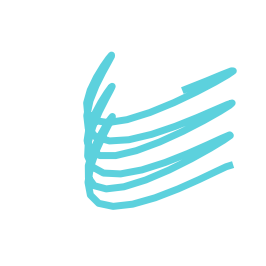

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

def animate(num, data, line):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',   '#7f7f7f', '#bcbd22', '#17becf']
    line.set_color(colors[num % len(colors)])
    line.set_alpha(0.7)
    line.set_data(data[0:2, :num])
    line.set_3d_properties(data[2, :num])
    return line

t = np.arange(0, 20, 0.2)
x = np.cos(t) - 1
y = 1 / 2 * (np.cos(2 * t) - 1)
data = np.array([x, y, t])
N = len(t)
fig = plt.figure()
ax = Axes3D(fig)
ax.axis('off')

line, = plt.plot(data[0], data[1], data[2], lw=7, c='red')
line_ani = animation.FuncAnimation(fig, animate, frames=N, fargs=(data, line), interval=50, blit=False)
line_ani.save('test.gif', writer='imagemagick')

# plt.show()

In [28]:
np_connections

NameError: name 'np_connections' is not defined

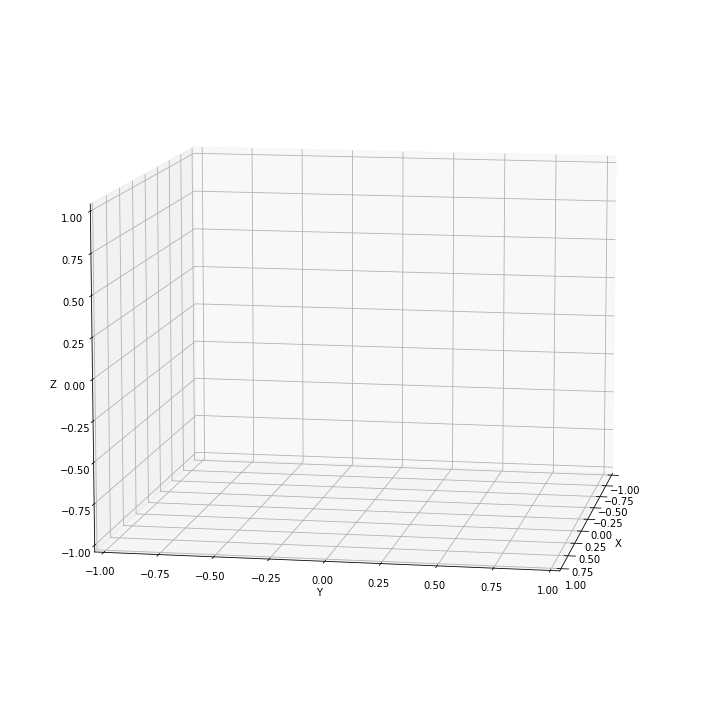

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import time

fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig)
ax = fig.add_subplot(111,projection='3d')
ax.view_init(elev=10, azim=10)
sc = ax.scatter([],[],[], c='darkblue', alpha=0.7, s=50)
line, = ax.plot([], [], [], c='darkgreen')


NUM_LANDMARKS = 33

def update(i, sc, line):
    # Update scatter points
    x_kps, y_kps, z_kps = [], [], []
    xyz_values = keypoints_dict[i]['nodes']
    
    assert len(xyz_values) == NUM_LANDMARKS

    
    for key_pt, xyz_tuples in xyz_values.items():
        x_kps.append(xyz_tuples[0])
        y_kps.append(xyz_tuples[1])
        z_kps.append(xyz_tuples[2])

    sc._offsets3d = (x_kps, y_kps, z_kps)
    
    
    # Update lines between points
    x_vals, y_vals, z_vals = [], [], []
    for connection in keypoints_dict[i]['connections']:
        # Draw connections using Pose Constant
#         np_connection = np.array(connection)
#         xy_val = np_connection[:,0:2]
#         print(xy_val.shape)
#         xy_vals.append(xy_val)
        
        x_vals.append([connection[0][0], connection[1][0]])
        y_vals.append([connection[0][1], connection[1][1]])
        z_vals.append([connection[0][2], connection[1][2]])
        
        
    np_connections = np.array(keypoints_dict[i]['connections'])   
    print("xy vals", np_connections[:2])

    print("z_vals", np_connections[2])

    line.set_data(np_connections[:2])
    # line.set_3d_properties(np_connections[2])
    
    # Issue is heeere - not working as intended. Try find work around or check input into function
    # line.set_3d_properties(z_vals)
    
    
    

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ani = matplotlib.animation.FuncAnimation(fig, update, frames=len(keypoints_dict), fargs=(sc, line), interval=200, repeat=True)
# ani.save('matplot003.gif', writer='imagemagick')

In [400]:
z_vals

array([0.26232022, 0.11437454])

In [300]:
len(df)

5

In [146]:
# xyz_points = np.array([(l[0].x, l[0].y, l[0].z) for l in landmarks])
# xyz_points

# df = pd.DataFrame(xyz_points, columns=["x","y","z"])
# keypoints_dict[0] = df
# df

,x,y,z
0,-0.065594,-0.493610,-0.488323
1,-0.052909,-0.489551,-0.480676
2,-0.060274,-0.484755,-0.468508
3,-0.063846,-0.487179,-0.486545
4,-0.066895,-0.518871,-0.465034


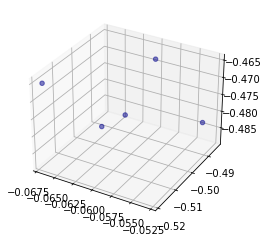

In [127]:
# fig = plt.figure()
# ax = fig.add_subplot(111,projection='3d')

# ax.scatter(xyz_points[:,0], xyz_points[:,1],  xyz_points[:,2], c='darkblue', alpha=0.5)
# plt.show()

/tmp/ipykernel_19129/1853286076.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
/home/ryan/.pyenv/versions/3.9.5/envs/computer-vision-cse-455-3.9.5/lib/python3.9/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


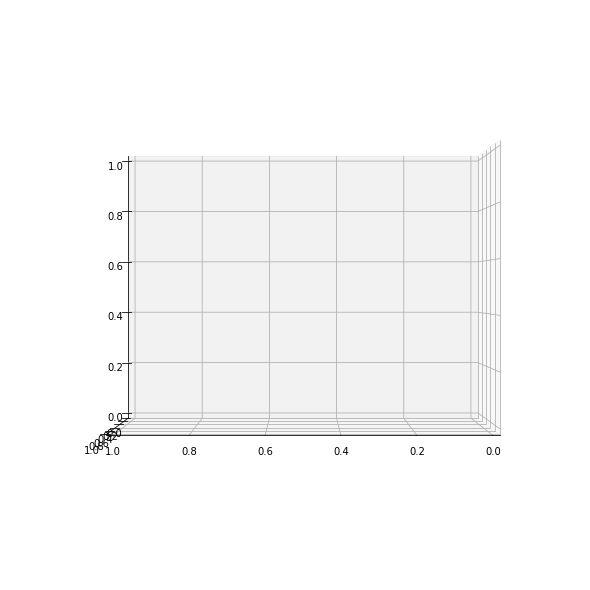

In [402]:
# import matplotlib; 
# matplotlib.use("TkAgg")
# import numpy as np
# import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d.axes3d as p3
# import matplotlib.animation as animation
# dotinline = 101
# nframe = 7
# fig = plt.figure(figsize=(16, 8))
# ax = p3.Axes3D(fig)
# ax.view_init(0, 90)


# def init():
#     ax.plot([-10, 10], [0, 0], [0, 0], "k")
#     ax.plot([0, 0], [-10, 10], [0, 0], "k")
#     ax.plot([0, 0], [0, 0], [-10, 10], "k")
#     ax.plot([], [], [], "b")


# def update_lines(index):
#     ax.cla()
#     init()
#     seg = []
#     x = np.linspace(-10, 10, dotinline)
#     power = x**(-(nframe-1)/2+index)
#     for i in range(len(x)-1):
#         a = [x[i+1], x[i]]
#         b = [0, 0]
#         c = [power[i+1], power[i]]
#         seg.append([a, b, c])
#     for data in seg:
#         ax.plot3D(data[0], data[1], data[2], "-b")


#     ax.set_xlim3d([-10, 10])
#     ax.set_xlabel('X')
#     ax.set_ylim3d([-10, 10])
#     ax.set_ylabel('Y')
#     ax.set_zlim3d([-10, 10])
#     ax.set_zlabel('Z')
#     ax.set_title('3D Test')


# line_ani = animation.FuncAnimation(fig, update_lines, init_func=init, frames=nframe, interval=2000, blit=False)

# plt.show()

In [23]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d
# from numpy import sin, cos, pi, outer, ones, size, linspace

# # Define x, y, z lists for sphere
# a = linspace(0, 2 * pi)
# b = linspace(0, pi)
# x = 10 * outer(cos(a), sin(b))
# y = 10 * outer(sin(a), sin(b))
# z = 10 * outer(ones(size(a)), cos(b))

# # The amount of frames in the animation
# frames = 26

# # Generate each frame
# for n in range(frames):
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(x, y, z, color=('b'))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_zticks([])
#     ax.set_xlim(-8,8)
#     ax.set_xlim(-8,8)
#     ax.set_xlim(-8,8)
#     plt.savefig(f"{n}.png")
#     plt.close()
    
#     # Add 1 to the x so the sphere moves right by 1
#     x += 1
#     y-=1
    
# image_names = [f"{i}.png" for i in range(frames)]
# save_images_as_gif(image_names, gif_name="ball.gif")

Done


In [21]:
from PIL import Image

def save_images_as_gif(image_names, gif_name):
    images = [Image.open(name) for name in image_names]
    images[0].save(gif_name, save_all=True, append_images=images[1:], duration=100, loop=0)
    
    print("Done")

## Load in video

In [ ]:
golf_side_slow_video_dir = "./inputs/golf/side_angle/slow/"
vids = get_filenames_in_folder(golf_side_slow_video_dir)
print("vids", vids)

video_path = os.path.join(golf_side_slow_video_dir, vids[0])
video_path

In [ ]:
def display_video(video_path):

    video = cv2.VideoCapture(video_path)

    while video.isOpened():

        # Capture the video frame by frame
        ret, frame = video.read()

        if frame is None:
            # After the loop release the cap object
            video.release()
            # Destroy all the windows
            cv2.destroyAllWindows()
            break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Display on image feed
        cv2.imshow('Holistic Pose Estimation Feed', img_rgb)

        # Press 'q' to close the videp
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break



In [ ]:
# display_video(video_path)

In [ ]:
def render_keypoints(frame, pose_world_landmarks, confidence_threshold: float = 0.5):
    pose_coords_3d = np.array([[(f.x, f.y, f.visibility) for f in result.pose_world_landmarks.landmark]]).squeeze()
    # pose_coords_2d = pose_coords_3d[:,0:2]

    x, y, c = frame.shape
    shaped = np.multiply(pose_coords_3d, [x, y, 1])

    for kp in shaped:    
        ky, kx, kp_coef = kp
        if kp_coef > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0, 255, 0), -1)
            print(kp)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

for result_ in result_arr:
    result, img = result_["results"], result_["img_rgb"] 
    
    render_keypoints(img, result.pose_world_landmarks)
    
    ax.imshow(img)
    # print("result", result)
    
    plt.show()
    break

In [ ]:
img.shape

In [ ]:
video_stream = cv2.VideoCapture(vid_path)

# Run MediaPipe Pose and plot 3d pose world landmarks.
with mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=1, 
) as pose:

    while video_stream.isOpened():
        # Capture the video frame by frame
        ret, frame = video_stream.read()

        if frame is None:
            break
            
        # stream_counter += 1
        # if not stream_counter % 5 == 0:
        #     continue

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


        results = pose.process(img_rgb)
        result_arr.append(results)
        # mp_drawing.plot_landmarks(results.pose_world_landmarks,  mp_pose.POSE_CONNECTIONS)
        

        # Display on image feed
        # cv2.imshow('Holistic Pose Estimation Feed', img_rgb)

        # Press 'q' to close the videp
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break